![Roboflow banner](https://user-images.githubusercontent.com/60797147/240767170-1793a92b-4ef7-469e-ae43-2a188ea9d2d3.jpeg)

# CLIP Search Engine

This notebook shows a search engine powered by CLIP and Roboflow Inference, an easy-to-use, production-ready inference server for computer vision supporting deployment of many popular model architectures and fine-tuned models.

We will be using the built-in CLIP endpoint with Roboflow Inference to calculate vectors to build a search engine.

In this guide, we will:

1. Install the required dependencies
2. Calculate embeddings for a dataset of images
3. Create a vector database that stores those images
4. Run an image search query on the database
5. (Optional): Run a text query on the database

## Install Dependencies

In [ ]:
!pip install faiss-gpu roboflow supervision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import base64
import os
from io import BytesIO
import cv2
import faiss
import numpy as np
import requests
from PIL import Image
import json
import roboflow
import supervision as sv

In [ ]:
roboflow.login()

roboflow.download_dataset(dataset_url="https://universe.roboflow.com/team-roboflow/coco-128/dataset/2", model_format="coco")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COCO-128-2 in coco:: 100%|██████████| 386/386 [00:00<00:00, 4448.22it/s]


## Define Functions for Calculating Embeddings

Below, we define functions that let us calculate embeddings.

In [ ]:
INFERENCE_ENDPOINT = "https://infer.roboflow.com"
API_KEY = ""
DATASET_PATH = "COCO-128-2"

In [ ]:
def get_image_embedding(image: str) -> dict:
    image = image.convert("RGB")

    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    image = base64.b64encode(buffer.getvalue()).decode("utf-8")

    payload = {
        "body": API_KEY,
        "image": {"type": "base64", "value": image},
    }

    data = requests.post(
        INFERENCE_ENDPOINT + "/clip/embed_image?api_key=" + API_KEY, json=payload
    )

    response = data.json()

    embedding = response["embeddings"]

    return embedding

In [ ]:
# def get_text(prompt):
#     text_prompt = requests.post(
#         f"{INFERENCE_ENDPOINT}/clip/embed_text?api_key={API_KEY}", json={"text": prompt}
#     ).json()["embeddings"]

#     return np.array(text_prompt)

## Build the Search Index

Below, we build a search index using Roboflow Inference.

In [ ]:
index = faiss.IndexFlatL2(512)
file_names = []

TRAIN_IMAGES = os.path.join(DATASET_PATH, "train")

for frame_name in os.listdir(TRAIN_IMAGES):
    try:
      frame = Image.open(os.path.join(TRAIN_IMAGES, frame_name))
    except IOError:
      print("error computing embedding for", frame_name)
      continue

    embedding = get_image_embedding(frame)

    index.add(np.array(embedding).astype(np.float32))

    file_names.append(frame_name)

faiss.write_index(index, "index.bin")

error computing embedding for _annotations.coco.json


## Run a Query

Below, we can pass in any image as a query and find related images in our dataset.

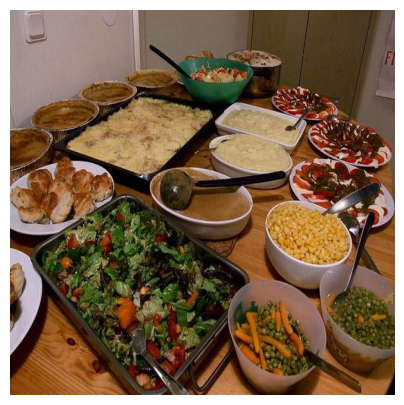

In [ ]:
to_compare = "000000000196_jpg.rf.8e48b2a4a9bd63fcd02ad61708d18ef2.jpg"
to_compare = os.path.join(DATASET_PATH, "train", to_compare)

query = get_image_embedding(Image.open(to_compare))

# query = get_text("san francisco")
# query = np.array(query).astype(np.float32)

D, I = index.search(np.array(query).astype(np.float32), 3)

image = cv2.imread(to_compare)

sv.plot_image(image, (5, 5))

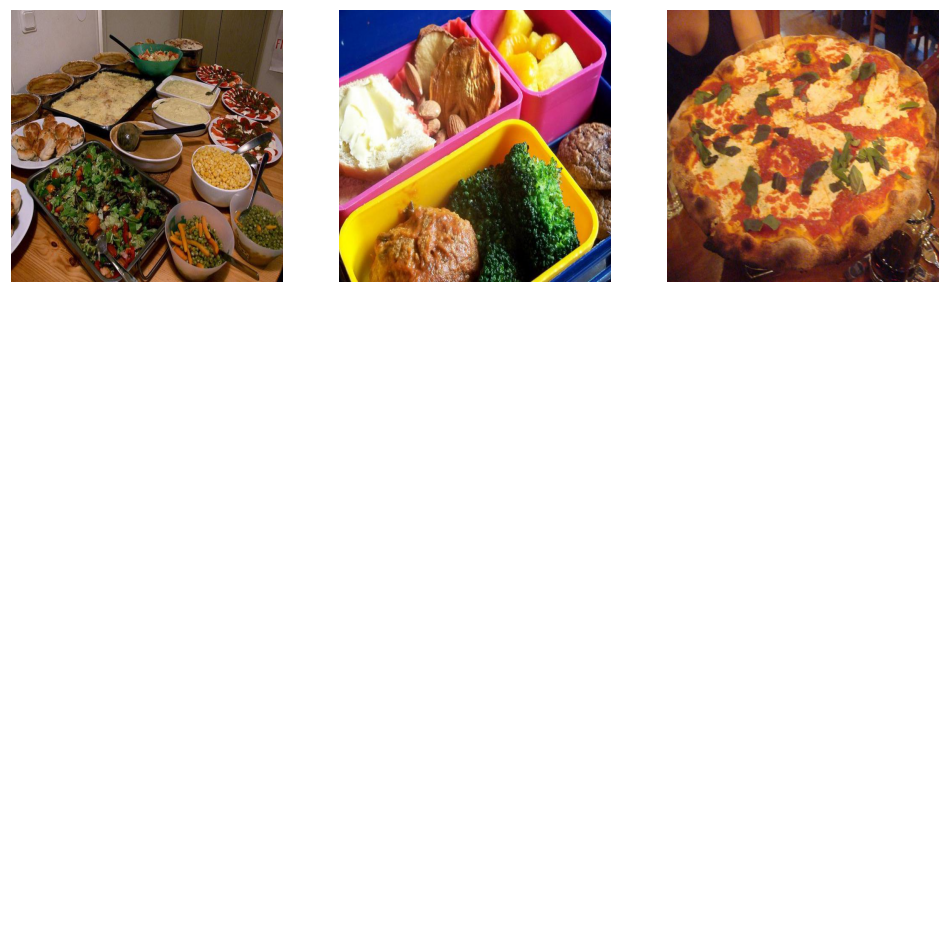

In [ ]:
# for i in I[0]:
#   print(file_names[i])
#   sv.plot_image(cv2.imread(os.path.join(TRAIN_IMAGES, file_names[i])), (3, 3))

images = [cv2.imread(os.path.join(TRAIN_IMAGES, file_names[i])) for i in I[0]]

sv.plot_images_grid(images, (3, 3))